In [39]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [40]:
ticker = "AAPL"
data = yf.download(ticker, start="2018-01-01", end="2023-01-01")

/tmp/ipykernel_5401/3633138759.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [41]:
data['SMA_5'] = data['Close'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['RSI'] = ta.momentum.RSIIndicator(data['Close'].squeeze(), window=14).rsi()
data['Typical'] = (data['High'] + data['Low'] + data['Close']) / 3
data['Target'] = data['Close'].shift(-1)

In [42]:
data.dropna(inplace=True)

In [43]:
def get_EMA(data, period):
    EMA_col = []
    EMA_col.append(data[f"SMA_{period}"].iloc[0])
    multiplier = 2 / (period + 1)
    for i in range(1, len(data)):
        EMA = (data[f"SMA_{period}"].iloc[i] - EMA_col[i-1]) * multiplier + EMA_col[i-1]
        EMA_col.append(EMA)
    return EMA_col

In [44]:
for period in [5,10]:
    data[f"EMA_{period}"] = get_EMA(data, period)

In [45]:
def get_TR(data):
    TR_col = [float(data["High"].iloc[0] - data["Low"].iloc[0])]
    for i in range(1, len(data)):
        TR = max(float(data["High"].iloc[i] - data["Low"].iloc[i]),
                 float(abs(data["High"].iloc[i] - data["Close"].iloc[i-1])),
                 float(abs(data["Low"].iloc[i] - data["Close"].iloc[i-1])))
        TR_col.append(TR)
    return TR_col

In [46]:
data["TR"] = get_TR(data)

/tmp/ipykernel_5401/265326435.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  TR_col = [float(data["High"].iloc[0] - data["Low"].iloc[0])]
/tmp/ipykernel_5401/265326435.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  TR = max(float(data["High"].iloc[i] - data["Low"].iloc[i]),
/tmp/ipykernel_5401/265326435.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(abs(data["High"].iloc[i] - data["Close"].iloc[i-1])),
/tmp/ipykernel_5401/265326435.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(abs(data["Low"].iloc[i] - data["Close"].iloc[i-1])))


In [47]:
features_LSTM = ["Close", "High", "Low", "Open", "Volume", "SMA_5", "SMA_10",
                 "RSI", "Typical", "EMA_5", "EMA_10", "TR"]

In [48]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [49]:
X_scaled = scaler_X.fit_transform(data[features_LSTM])
y_scaled = scaler_y.fit_transform(data[['Target']])

In [50]:
train_size = int(len(data) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [51]:
look_back = 20
def create_LSTM_dataset(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X)-look_back):
        Xs.append(X[i:(i+look_back), :])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

In [52]:
X_train_LSTM, y_train_LSTM = create_LSTM_dataset(X_train, y_train, look_back)
X_test_LSTM, y_test_LSTM = create_LSTM_dataset(X_test, y_test, look_back)

In [53]:
tf.random.set_seed(36)
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, X_train_LSTM.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0241
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010  
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7905e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7784e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9722e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2724e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7948e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5185e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3405e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2137e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1176e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0437e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9885e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9486e-04
Epoch 15/50
61/61 ━━━━━━━━━━━━━━━━━

In [55]:
train_pred = model.predict(X_train_LSTM)
test_pred = model.predict(X_test_LSTM)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [56]:
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_inv = scaler_y.inverse_transform(y_train_LSTM)
test_pred_inv = scaler_y.inverse_transform(test_pred)
y_test_inv = scaler_y.inverse_transform(y_test_LSTM)

In [57]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 2.38
Test RMSE: 4.69


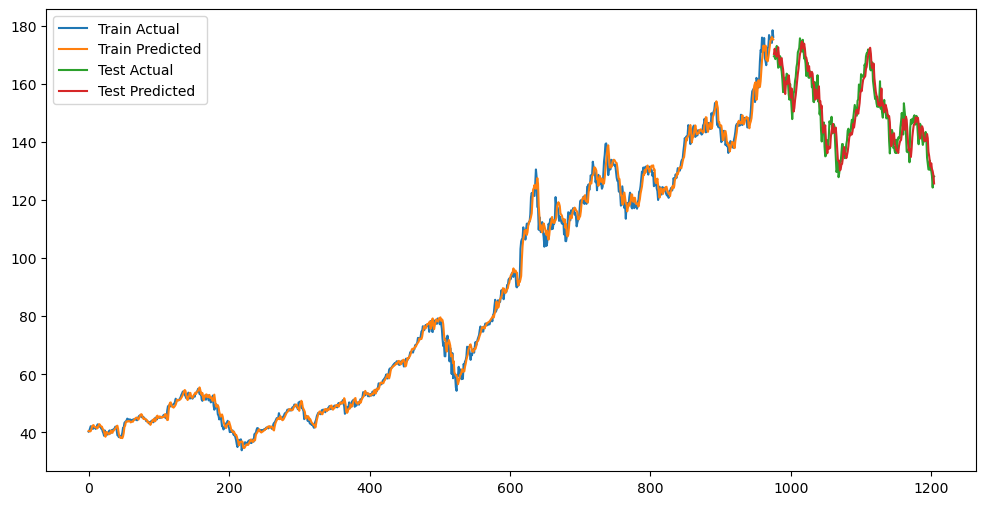

In [58]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv)), train_pred_inv, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_test_inv)), y_test_inv, label='Test Actual')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(test_pred_inv)), test_pred_inv, label='Test Predicted')
plt.legend()
plt.show()